# Import libraries

In [11]:
import os
import math
import random
import numpy as np
import matplotlib.pyplot as plt
from os.path import join
from itertools import tee
from scipy.sparse import spdiags
from mlxtend.data import loadlocal_mnist

# Logistic Regression algorithm

## Logistic Regression build

### Logistic Regression matirces build

In [12]:
def Logistic_Regression(w, x, y, hessian_indicator=True):
    Cost_Fw = cost(w, x, y)
    Gradient_Fw = gradient(w, x, y)
    if hessian_indicator:
        Hessian_Fw = hessian(w, x, y)
        return Cost_Fw, Gradient_Fw, Hessian_Fw
    else:
        return Cost_Fw, Gradient_Fw

### Net input

In [13]:
def net_input(x, w):
    return np.dot(x.transpose(), w)

### Sigmoid

In [14]:
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

### Cost

In [15]:
def cost(w, x, y):
    m = x.shape[1]
    c1 = y
    c2 = 1 - y
    probability = sigmoid(net_input(x, w))
    return -(1 / m) * (c1.transpose() @ np.log(probability) + c2.transpose() @ np.log(1 - probability))

### Gradient

In [16]:
def gradient(w, x, y):
    m = x.shape[1]
    c1 = y
    probability = sigmoid(net_input(x, w))
    return (1 / m) * (x @ (probability - c1))

### Hessian

In [17]:
def hessian(w, x, y):
    m = y.shape[0]
    probability = sigmoid(net_input(x, w))
    probability_multiplication = probability * (1 - probability)
    D = np.asarray(probability_multiplication.transpose())[0]
    return (1 / m) * (np.multiply(x, D) @ x.transpose())

## Logistic Regression testing algorithms prebuild

### Getting train and test data

In [19]:
training_images_filepath = 'train-images.idx3-ubyte'
training_labels_filepath = 'train-labels.idx1-ubyte'
test_images_filepath = 't10k-images.idx3-ubyte'
test_labels_filepath = 't10k-labels.idx1-ubyte'

xTrain, yTrain = loadlocal_mnist(images_path=training_images_filepath, labels_path=training_labels_filepath)
xTest, yTest = loadlocal_mnist(images_path=test_images_filepath, labels_path=test_labels_filepath)
xTrain = xTrain / np.max(xTrain)
xTest = xTest / np.max(xTest)

### Filtering digits

In [20]:
def filter_data_for_digits(digit_1, digit_2):
    # Filter train data
    train_indexes = (i for i in range(xTrain.shape[0]) if yTrain[i] in [digit_1, digit_2])
    train_index_1, train_index_2 = tee(train_indexes)
    x_train = np.array([xTrain[i] for i in train_index_1]).transpose()
    y_train_array = np.array([yTrain[i] for i in train_index_2])
    y_train = np.array([y_train_array]).transpose() % 8

    # Filter test data
    test_indexes = (i for i in range(xTest.shape[0]) if yTest[i] in [digit_1, digit_2])
    test_index_1, test_index_2 = tee(test_indexes)
    x_test = np.array([xTest[i] for i in test_index_1]).transpose()
    y_test_array = np.array([yTest[i] for i in test_index_2])
    y_test = np.array([y_test_array]).transpose() % 8
    return x_train, y_train, x_test, y_test

### Calculating Accuracy

In [21]:
def accuracy(digit_1, digit_2, x, y, w):
    # Compute accuracy rate
    y = y.transpose()[0]
    x = x.transpose()
    total_correct_digit_1 = len([i for i in range(len(x)) if (y[i] == digit_1) and (sigmoid(x[i] @ w) > 0.5)])
    total_correct_digit_2 = len([i for i in range(len(x)) if (y[i] == digit_2) and (sigmoid(x[i] @ w) <= 0.5)])
    total_correct_digits = total_correct_digit_1 + total_correct_digit_2
    return float(total_correct_digits) / len(x)

### Fitting the data

In [22]:
def fit_train_and_test(digit_1, digit_2, gradient_descent_indicator=True):
    # Trains the model from the training data, and tests the model from the testing data
    x_train, y_train, x_test, y_test = filter_data_for_digits(digit_1, digit_2)
    w = np.zeros((x_train.shape[0], 1))
    if gradient_descent_indicator:
        w, train_cost_history, test_cost_history = Gradient_Descent(w, x_train, 1-y_train, x_test, 1-y_test)
    else:
        w, train_cost_history, test_cost_history = Exact_Newton(w, x_train, 1-y_train, x_test, 1-y_test)
    accuracy_rate = accuracy(digit_1 % 8, digit_2 % 8, x_test, y_test, w)
    return (np.abs(train_cost_history - train_cost_history[-1]), np.abs(test_cost_history - test_cost_history[-1]),
            accuracy_rate, test_cost_history[-1], w)

### Gradient Descent algorithm for Logistic Regression

In [23]:
def Gradient_Descent(w, x_train, y_train, x_test, y_test, alpha=1.0, iterations=100):
    train_cost_history = []
    test_cost_history = []
    d = np.zeros(w.shape)
    g_k = np.zeros(w.shape)
    f_k = 1
    for i in range(iterations):
        w = np.clip(w, -1, 1)
        if i != 0:
            alpha = Armijo_Linesearch(w, x_train, y_train, d, g_k)
        w += alpha * d
        if f_k < 1e-3:
            break
        f_k, g_k = Logistic_Regression(w, x_train, y_train, hessian_indicator=False)
        d = -np.array(g_k)
        f_0 = cost(w, x_test, y_test)
        train_cost_history.append(f_k[0][0])
        test_cost_history.append(f_0[0][0])
    return w, np.array(train_cost_history), np.array(test_cost_history)

### Exact_Newton algorithm for Logistic Regression

In [24]:
def Exact_Newton(w, x_train, y_train, x_test, y_test, alpha=1.0, iterations=100):
    train_cost_history = []
    test_cost_history = []
    d = np.zeros(w.shape)
    g_k = np.zeros(w.shape)
    f_k = 1
    for i in range(iterations):
        w = np.clip(w, -1, 1)
        if i != 0:
            alpha = Armijo_Linesearch(w, x_train, y_train, d, g_k)
        w += alpha * d
        if f_k < 1e-3:
            break
        f_k, g_k, h_k = Logistic_Regression(w, x_train, y_train)
        h_k_regulated = h_k + (np.identity(h_k.shape[0]) * 1e-2)
        d = -np.linalg.inv(h_k_regulated) @ g_k
        f_0 = cost(w, x_test, y_test)
        train_cost_history.append(f_k[0][0])
        test_cost_history.append(f_0[0][0])
    return w, np.array(train_cost_history), np.array(test_cost_history)

### Armijo Linesearch

In [25]:
def Armijo_Linesearch(w, x, y, d, g_k, alpha=1.0, beta=0.8, c=1e-5):
    f_k = cost(w, x, y)
    for i in range(10):
        f_k_1 = cost(w + (alpha * d), x, y)
        if f_k_1 <= f_k + (alpha * c * np.dot(d.transpose(), g_k)):
            return alpha
        else:
            alpha = beta * alpha
    return alpha

## Testing the Logistic Regression

Gradient Descent 0 vs 1 - CALCULATION DONE
Exact Newton 0 vs 1 - CALCULATION DONE
Gradient Descent 8 vs 9 - CALCULATION DONE
Exact Newton 8 vs 9 - CALCULATION DONE


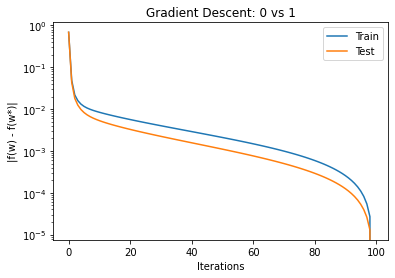

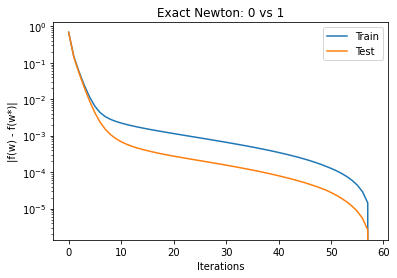

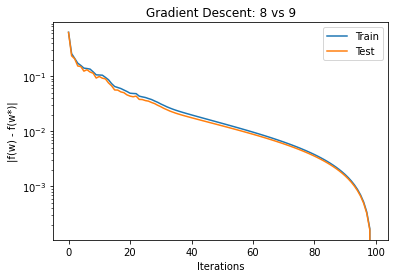

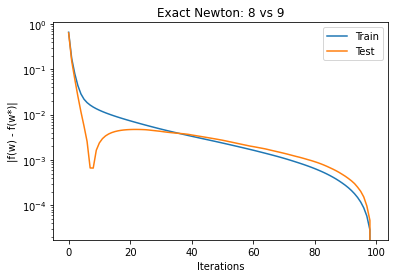

Success rate in each test data per method:
Gradient Descent: 0 vs 1 = 99.95271867612293%
Exact Newton: 0 vs 1 = 99.95271867612293%
Gradient Descent: 8 vs 9 = 97.42813918305598%
Exact Newton: 8 vs 9 = 97.98285426122038%

Final objective value in each test data per method:
Gradient Descent: 0 vs 1 = 0.0034524460542196007
Exact Newton: 0 vs 1 = 0.0017199604720794766
Gradient Descent: 8 vs 9 = 0.07296692800850346
Exact Newton: 8 vs 9 = 0.05435210942934455


In [26]:
gd_0v1 = fit_train_and_test(0, 1, gradient_descent_indicator=True)
print("Gradient Descent 0 vs 1 - CALCULATION DONE")
en_0v1 = fit_train_and_test(0, 1, gradient_descent_indicator=False)
print("Exact Newton 0 vs 1 - CALCULATION DONE")
gd_8v9 = fit_train_and_test(8, 9, gradient_descent_indicator=True)
print("Gradient Descent 8 vs 9 - CALCULATION DONE")
en_8v9 = fit_train_and_test(8, 9, gradient_descent_indicator=False)
print("Exact Newton 8 vs 9 - CALCULATION DONE")

fig1, axs1 = plt.subplots()
fig2, axs2 = plt.subplots()
fig3, axs3 = plt.subplots()
fig4, axs4 = plt.subplots()
axs1.plot(gd_0v1[0], label="Train")
axs1.plot(gd_0v1[1], label="Test")
axs2.plot(en_0v1[0], label="Train")
axs2.plot(en_0v1[1], label="Test")
axs3.plot(gd_8v9[0], label="Train")
axs3.plot(gd_8v9[1], label="Test")
axs4.plot(en_8v9[0], label="Train")
axs4.plot(en_8v9[1], label="Test")

axs1.set_yscale('log')
axs2.set_yscale('log')
axs3.set_yscale('log')
axs4.set_yscale('log')

axs1.set_ylabel('|f(w) - f(w*)|')
axs2.set_ylabel('|f(w) - f(w*)|')
axs3.set_ylabel('|f(w) - f(w*)|')
axs4.set_ylabel('|f(w) - f(w*)|')

axs1.set_xlabel('Iterations')
axs2.set_xlabel('Iterations')
axs3.set_xlabel('Iterations')
axs4.set_xlabel('Iterations')

axs1.set_title('Gradient Descent: 0 vs 1')
axs2.set_title('Exact Newton: 0 vs 1')
axs3.set_title('Gradient Descent: 8 vs 9')
axs4.set_title('Exact Newton: 8 vs 9')

axs1.legend()
axs2.legend()
axs3.legend()
axs4.legend()
plt.show()

print('Success rate in each test data per method:')
print('Gradient Descent: 0 vs 1 = ' + str(gd_0v1[2] * 100) + '%')
print('Exact Newton: 0 vs 1 = ' + str(en_0v1[2] * 100) + '%')
print('Gradient Descent: 8 vs 9 = ' + str(gd_8v9[2] * 100) + '%')
print('Exact Newton: 8 vs 9 = ' + str(en_8v9[2] * 100) + '%' + '\n')

print('Final objective value in each test data per method:')
print('Gradient Descent: 0 vs 1 = ' + str(gd_0v1[3]))
print('Exact Newton: 0 vs 1 = ' + str(en_0v1[3]))
print('Gradient Descent: 8 vs 9 = ' + str(gd_8v9[3]))
print('Exact Newton: 8 vs 9 = ' + str(en_8v9[3]))